# Implementation

## Setup

In [1]:
# Numpy is our workhorse

# On Colab runtimew with GPU, try using cupy
# https://cupy.dev/
# https://stackoverflow.com/q/9727688
# ! nvcc --version
# ! pip install cupy-cuda11x

# Internal code raises a tonne of these:
# TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

# Workaround - Get module name from module alias
# Frequent conversions result in almost same performance as numpy
# Use pytorch, tensorflow for parallelized neural networks

# https://stackoverflow.com/q/67365889/

# if (np.__name__ == 'cupy'):
#     _X = self.X.get()
#     _y = self.y.get()

# if (np.__name__ == 'numpy'):
#     _X = self.X
#     _y = self.y

# Monkey Patch for UTF-8 locale
# https://stackoverflow.com/a/75419862/

# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Pretty printing arrays for debugging
def adjoin(*objs, **kwds):
    from pandas.io.formats.printing import adjoin as adj
    space = kwds.get('space', 8)
    reprs = [repr(obj).split('\n') for obj in objs]
    print(adj(space, *reprs), '\n\n')

In [2]:
# "Feed-Forward Multilayer Perceptron Model" - Intuition
# 4 inputs neurons, 3 output neurons, no hidden layers

inputs = [1, 2, 3 , 2.5]
weights = [
    [0.2, 0.8, -0.5, 1.0],
    [0.5, -0.91, 0.26, -0.5],
    [-0.26, -0.27, 0.17, 0.87]
]
bias = [2, 3, 0.5]

outputs = [
    sum(x * y for x,y in zip(inputs, w_i)) + b_i
    for w_i, b_i in zip(weights, bias)
]

outputs

[4.8, 1.21, 2.385]

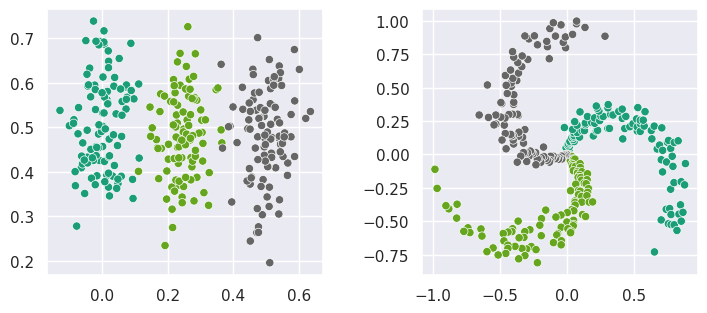

In [3]:
class SampleClassData:

    def __init__(self, samples_per_class=100, no_of_classes=3, *, dist=None, plot_axis=None):
        np.random.seed(0) # debugging
        self.N = samples_per_class
        self.M = no_of_classes
        self.X = np.zeros(shape=(self.N*self.M, 2))
        self.y = np.zeros(shape=(self.N*self.M,), dtype='uint8')

        funcs = {'S': self.spiral, 'V': self.vertical}

        assert dist in funcs, "Specify data class"
        funcs.get(dist, 'V')()

        if (plot_axis != None):
            sns.scatterplot(x=self.X[:,0], y=self.X[:,1], c=self.y, cmap='Dark2', ax=plot_axis)

    def spiral(self):
        # 2D spiral -> angular points from 'growing' circles

        for i in range(self.M):
            index = range(self.N*i, self.N*(i+1))
            radii = np.linspace(0, 1, self.N)  # Increasing Radii
            arcsz = (np.pi * 2) / self.M       # For symmetrical alignment
            theta = np.linspace(i * arcsz, (i+1) * arcsz, self.N)
            noise = np.random.randn(self.N) * 0.2
            angle = theta + noise

            self.X[index] = np.vstack((radii * np.sin(angle), radii * np.cos(angle))).T
            self.y[index] = i

    def vertical(self):
        for i in range(self.M):
            index = range(self.N*i, self.N*(i+1))
            _x = np.random.randn(self.N) * 0.05 + i/4
            _y = np.random.randn(self.N) * 0.1  + 0.5

            self.X[index] = np.vstack((_x, _y)).T
            self.y[index] = i

fig, axs = plt.subplots(1,2, sharex=False, sharey=False, figsize=(8,4))
fig.tight_layout(pad=3)
a=SampleClassData(dist='V', plot_axis=axs[0]);
b=SampleClassData(dist='S', plot_axis=axs[1]);

## Layers, Activation

In [4]:
# We will separate base layers and act layers
# Each layer.backward sends ∂C/∂y to previous layer

class Dense():
    def __init__(self, n_input_features, n_neurons, scaler=None):
        # Random weights -> all outputs nearly equal
        self.i = n_input_features
        self.j = n_neurons

        # scaler must implement fit_transform
        self.scaler = scaler

        # Glorot Initialization
        params_dict = {
            'low' : -np.sqrt(10/self.i),
            'high':  np.sqrt(10/self.i),
            'size': (self.i, self.j),
        }

        self.weights = np.random.uniform(**params_dict)
        self.biases  = np.zeros(shape=(1, self.j))

    def __str__(self):
        return f"Dense({self.i} -> {self.j})"

    def forward(self, inputs):
        self.inputs  = inputs
        self.out = inputs @ self.weights + self.biases

        if (self.scaler != None):
            self.out = self.scaler.fit_transform(self.out)
        return self.out

    def backward(self, output_gradients, alpha):
        """
        1. ∂C/∂X = ∂C/∂y @ W.T  -> B4 changing W & B
        2. ∂C/∂W = X.T @ ∂C/∂y
        3. ∂C/∂B = ∂C/∂y
        """
        self.outG = output_gradients
        self.inpG = self.outG @ self.weights.T
        self.weights -= alpha * (self.inputs.T @ self.outG)
        self.biases  -= np.sum(alpha * self.outG, axis=0).reshape(1,-1)
        return self.inpG

In [5]:
class Activation():
    def __init__(self, func, d_dx):
        self.biases = [[0]]  # Compatibility
        self.activation = func
        self.derivative = d_dx

    def forward(self, inputs):
        self.inputs = inputs
        return self.activation(inputs)

    def backward(self, output_gradient, alpha):
        """
        ∂C/∂X = ∂C/∂y ⊙ F'(X)
        """
        return output_gradient * self.derivative(self.inputs)


class ReLU(Activation):
    def __init__(self):
        # np.max is diff from np.maximum
        relu = lambda x: np.maximum(0, x)
        d_dx = lambda x: (x > 0)
        super().__init__(relu, d_dx)


class TanH(Activation):
    def __init__(self):
        d_dx = lambda x: 1 - np.tanh(x) ** 2
        super().__init__(np.tanh, d_dx)


In [6]:
class Sigmoid(Activation):
    def __init__(self):
        super().__init__(self.sigmoid, self.d_dx)

    def sigmoid(self, inputs):
        try:
            self.exps = np.exp(-inputs)
        except FloatingPointError:
            print(inputs)
        return 1/(1+self.exps)

    def d_dx(self, inputs):
        return -self.exps / (1+self.exps)**2
# Generalization of sigmoid to vectors
# SoftMax -> Vector Output -> "Gradient" is meaningless
# Derivative -> Jacobian. We will simply pass
# output gradients as inputs gradients

class SoftMax(Activation):
    def __init__(self):
        super().__init__(self.softmax, lambda x: x)

    def softmax(self, inputs):
        # Handle Overflow
        inputs -= np.max(input, axis=1, keepdims=True)
        # Handle Underflow
        inputs  = np.clip(input, a_min=-7, a_max=0)
        exps = np.exp(inputs)

        self.soft_op = exps/np.sum(exps, axis=1, keepdims=True)
        return self.soft_op

## Wrapper class

In [7]:
# Mean Squared Error
# Set as the default Loss function in Network
class Loss_MSE():
    def forward(self, y_pred, y_true):
        # Demands 2D OHE Labels/ Values for performance
        if not (y_pred.shape == y_true.shape and y_true.ndim == 2):
            adjoin(y_pred, y_true)
            raise ValueError("Shape Mismatch between predictions and labels")

        self.diff = y_pred-y_true

        if (self.diff.shape[1] == 1):
            # (N,1)  -> Regression
            self.accu = np.mean(abs(self.diff) < 1e-6)
        else:
            # (N,K)  -> K-class classification, with One-Hot Encoded Labels
            self.accu = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

        self.loss = np.mean((self.diff)**2)
        return self.loss

    def backward(self):
        self.grad = 2 * (self.diff) / len(self.diff)
        return self.grad

# Categorical Cross Entropy
# Li = -sum(y_true * log(y_pred_prob))
# Li = -log(y_prob[y_true_ohe])
# ∂L/∂X = y_pred_prob - y_true_one_hot
# Gradients are similar to those of MSE, with OHE labels

In [8]:
class Network:
    """
    1. Propagate forward through all layers
    2. Calculate Cost, Gradient of Cost
    3. Regularize Gradients
    4. Backpropagate through all layers
    """

    def __init__(self, *layers):
        self.layers = layers
        self.loss_f = Loss_MSE()

    def predict(self, X):
        assert X.ndim==2, "X has to be a 2D array"
        self.out = X
        for L in self.layers:
            self.out = L.forward(self.out)
        return self.out

    def backprop(self, alpha):
        # Expects self.grad to be defined in fit
        # We are using same learning-rate for all layers
        for L in self.layers[::-1]:
            self.grad = L.backward(self.grad, alpha)

    def gradAutoClip(self, iteration, clip_p):
        # Ref: github.com/pseeth/autoclip
        norm = np.sum( self.grad ** 2 ) ** 0.5
        self.grad_norms[iteration] = norm
        norm_p = np.percentile(self.grad_norms, clip_p)

        if (norm > norm_p and norm_p != 0):
            self.grad *= norm_p/norm

    def fit(self, X, y, *, alpha=5e-2, epochs=1000, clip_p=20, debug=[]):
        # For AutoClipping gradients
        assert X.ndim==2, "X has to be a 2D array"
        self.grad_norms = np.zeros(shape=(epochs,))

        for i in range(epochs):
            pred = self.predict(X)
            self.loss = self.loss_f.forward(pred, y)
            self.grad = self.loss_f.backward()
            self.gradAutoClip(i, clip_p)
            self.backprop(alpha)

            if i+1 in debug:
                with np.printoptions(precision=4):
                    # https://stackoverflow.com/a/59158545/
                    # https://stackoverflow.com/a/71801560/
                    trunc = int(np.ceil(np.log10(epochs)) + 1)
                    print(f"Epoch: {i+1:{trunc}d}",end='    ')
                    print(f"Loss : {self.loss :.5e}",end='    ')
                    print(f"Accuracy : {self.loss_f.accu:.5e}")
                    print('-'*(55+trunc))

# Testing

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False, dtype='uint8')
# Numpy, Pyplot, Seaborn already imported in 'Implementation'

## XOR circuit

In [10]:
# XOR is the most fundamental nonlinear data
# Widely used for testing Neural Networks

X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ 0,1,1,0 ]).reshape(-1,1)

neunet = Network(
    Dense(2,4, scaler=StandardScaler()),
    Dense(4,4),
    # TanH(),
    ReLU(),
    # Sigmoid(),
    Dense(4,1),
)

neunet.fit(X, y, debug=[100,500,1000])
np.round(np.clip(neunet.predict(X), 1e-4, 1-1e-4), 3)

Epoch:  100    Loss : 1.48658e-01    Accuracy : 0.00000e+00
-----------------------------------------------------------
Epoch:  500    Loss : 2.25870e-05    Accuracy : 0.00000e+00
-----------------------------------------------------------
Epoch: 1000    Loss : 3.77771e-10    Accuracy : 2.50000e-01
-----------------------------------------------------------


array([[0.],
       [1.],
       [1.],
       [0.]])

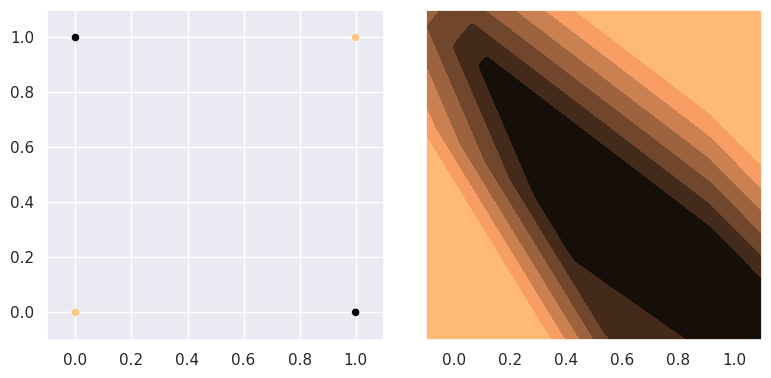

In [11]:
XX, YY = np.meshgrid(
    np.linspace(X[:,0].min()-1e-1, X[:,0].max()+1e-1, 100),
    np.linspace(X[:,1].min()-1e-1, X[:,1].max()+1e-1, 100)
)

fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,4))
fig.tight_layout()

ZZ = neunet.predict(np.c_[XX.ravel(), YY.ravel()])
ZZ = np.round(np.clip(ZZ, 1e-4, 1-1e-4), 3)
# ZZ = np.argmax(ZZ, axis=1)
ZZ = ZZ.reshape(XX.shape)

sns.scatterplot(x=X[:,0], y=X[:,1], c=y, cmap='copper_r', ax=axs[0])
axs[1].contourf(XX, YY, ZZ, cmap='copper_r');

## Vertical DataSet

In [12]:
data = SampleClassData(dist='V')
ohce = OHE.fit_transform(np.vstack(data.y))
# Maybe overfitting?
neunet = Network(
    Dense(2,100),
    TanH(),
    Dense(100,3),
    TanH(),
    Dense(3,3),
    TanH(), ReLU(),
)

neunet.fit(data.X, ohce, debug=[10,100,500,1000], epochs=1000)
print("Final Accuracy: ", end=' ')
print(np.mean(np.argmax(neunet.predict(data.X), axis=1) == data.y), end='\n\n')

Epoch:   10    Loss : 1.84684e-01    Accuracy : 6.66667e-01
-----------------------------------------------------------
Epoch:  100    Loss : 2.51961e-02    Accuracy : 9.76667e-01
-----------------------------------------------------------
Epoch:  500    Loss : 9.43983e-03    Accuracy : 9.86667e-01
-----------------------------------------------------------
Epoch: 1000    Loss : 7.05462e-03    Accuracy : 9.90000e-01
-----------------------------------------------------------
Final Accuracy:  0.99



In [13]:
adjoin(np.argmax(neunet.predict(data.X), axis=1), data.y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,        array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,               1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,          

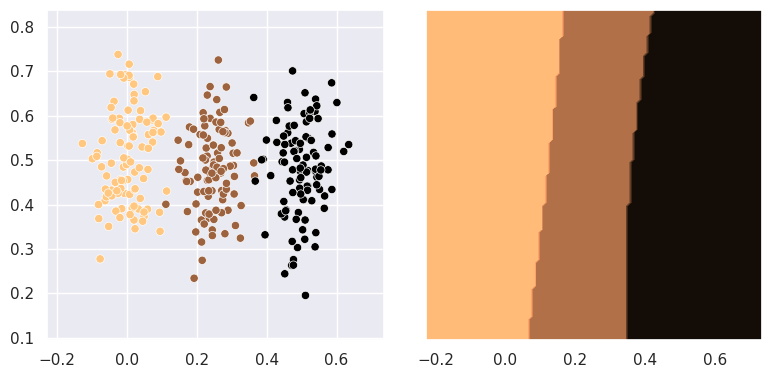

In [14]:
XX, YY = np.meshgrid(
    np.linspace(data.X[:,0].min()-1e-1, data.X[:,0].max()+1e-1, 100),
    np.linspace(data.X[:,1].min()-1e-1, data.X[:,1].max()+1e-1, 100)
)

fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,4))
fig.tight_layout()

ZZ = neunet.predict(np.c_[XX.ravel(), YY.ravel()])
# ZZ = np.round(np.clip(ZZ, 1e-4, 1-1e-4), 3)
ZZ = np.argmax(ZZ, axis=1)
ZZ = ZZ.reshape(XX.shape)

sns.scatterplot(x=data.X[:,0], y=data.X[:,1], c=data.y, cmap='copper_r', ax=axs[0])
axs[1].contourf(XX, YY, ZZ, cmap='copper_r');

## Spiral Dataset

In [15]:
data = SampleClassData(dist='S')
ohce = OHE.fit_transform(np.vstack(data.y))
# Scaling gives mild boost to accuracy
neunet = Network(
    Dense(2,100),
    TanH(),
    Dense(100,3, scaler=StandardScaler()),
    TanH(),
    Dense(3,3, scaler=StandardScaler()),
    TanH(), ReLU(),
)

neunet.fit(data.X, ohce, debug=[10,100,500,1000,5000], epochs=5000)
print("Final Accuracy: ", end=' ')
print(np.mean(np.argmax(neunet.predict(data.X), axis=1) == data.y), end='\n\n')

Epoch:    10    Loss : 2.25290e-01    Accuracy : 4.40000e-01
------------------------------------------------------------
Epoch:   100    Loss : 6.04702e-02    Accuracy : 9.30000e-01
------------------------------------------------------------
Epoch:   500    Loss : 4.59633e-02    Accuracy : 9.56667e-01
------------------------------------------------------------
Epoch:  1000    Loss : 3.50678e-02    Accuracy : 9.63333e-01
------------------------------------------------------------
Epoch:  5000    Loss : 1.53397e-02    Accuracy : 9.93333e-01
------------------------------------------------------------
Final Accuracy:  0.9933333333333333



In [16]:
adjoin(np.argmax(neunet.predict(data.X), axis=1), data.y)

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,        array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,               1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,          

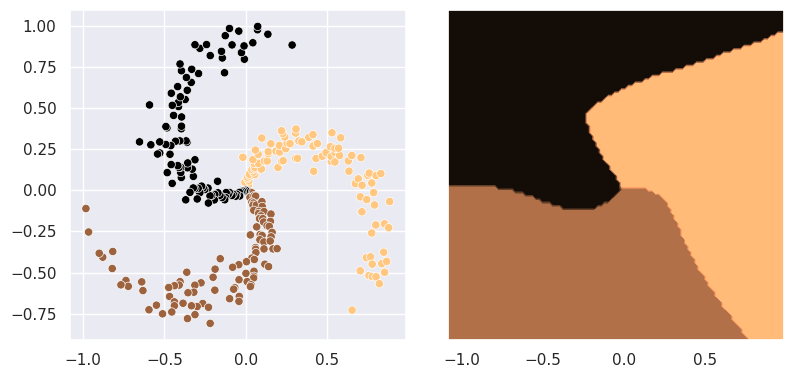

In [17]:
XX, YY = np.meshgrid(
    np.linspace(data.X[:,0].min()-1e-1, data.X[:,0].max()+1e-1, 100),
    np.linspace(data.X[:,1].min()-1e-1, data.X[:,1].max()+1e-1, 100)
)

fig, axs = plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,4))
fig.tight_layout()

ZZ = neunet.predict(np.c_[XX.ravel(), YY.ravel()])
# ZZ = np.round(np.clip(ZZ, 1e-4, 1-1e-4), 3)
ZZ = np.argmax(ZZ, axis=1)
ZZ = ZZ.reshape(XX.shape)

sns.scatterplot(x=data.X[:,0], y=data.X[:,1], c=data.y, cmap='copper_r', ax=axs[0])
axs[1].contourf(XX, YY, ZZ, cmap='copper_r');

## MNIST handwritten digits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  82.3M      0 --:--:-- --:--:-- --:--:-- 82.3M


 (60000, 784) (10000, 784) (60000, 10) (10000,) 




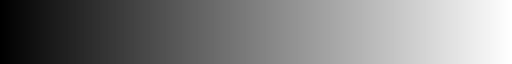

In [18]:
# https://datascience.stackexchange.com/a/117283
# https://stats.stackexchange.com/q/376312

mnist_url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"

! curl {mnist_url} -o mnist.npz
data = np.load('./mnist.npz')

# Data Preparation
# Flatten (N,28,28) images to (N,784)
# One Hot Encode Training Labels

X_train = data['x_train'].reshape(-1,784)
X_test  = data['x_test'].reshape(-1,784)
y_train = OHE.fit_transform(np.vstack(data['y_train']))
y_test  = data['y_test']

print('\n\n', X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n\n')
cmap = sns.color_palette("blend:black,white", as_cmap=True)
cmap

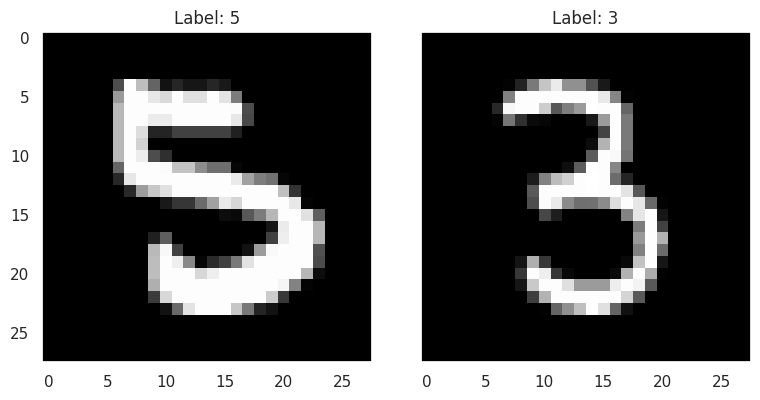

In [19]:
i0 = np.random.choice(range(len(X_train)))
i1 = np.random.choice(range(len(X_test)))

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey=True)
fig.tight_layout()

img0 = X_train[i0].reshape(28,28)
img1 = X_test[i1].reshape(28,28)
lab0 = np.argmax(y_train[i0])
lab1 = y_test[i1]


axs[0].grid(False)
axs[0].imshow(img0, cmap=cmap)
axs[0].set_title(f"Label: {lab0}")

axs[1].grid(False)
axs[1].imshow(img1, cmap=cmap)
axs[1].set_title(f"Label: {lab1}")
pass

# with np.printoptions(linewidth=1000):
#     adjoin(img1, lab1)
#     adjoin(img2, lab2)

In [20]:
# TanH+ReLU -> attempt to replace Sigmoid+SoftMax
neunet = Network(
    Dense(784, 20),
    TanH(),
    Dense(20, 10),
    TanH(), ReLU(),
)

neunet.fit(X_train, y_train, epochs=1000, debug=[10,50,100,500,1000])

Epoch:   10    Loss : 1.00286e-01    Accuracy : 1.73983e-01
-----------------------------------------------------------
Epoch:   50    Loss : 7.96850e-02    Accuracy : 3.68233e-01
-----------------------------------------------------------
Epoch:  100    Loss : 6.67589e-02    Accuracy : 4.84333e-01
-----------------------------------------------------------
Epoch:  500    Loss : 3.21011e-02    Accuracy : 7.72700e-01
-----------------------------------------------------------
Epoch: 1000    Loss : 2.77424e-02    Accuracy : 7.99533e-01
-----------------------------------------------------------


In [21]:
pred = np.argmax(neunet.predict(X_test), axis=1)
print(pred)
print(f"Accuracy: {np.mean(pred == y_test)}")

[7 2 1 ... 0 8 6]
Accuracy: 0.7894


# Debugging Notes

* Method: Handling numpy warnings as errors
 >* olderr = numpy.seterr(all='raise')
 >* exception handling
 >* olderr = numpy.seterr(\*\*olderr)

* Checks:
 >* Check if XOR circuit works well, after each tweak
 >* Overflow, Underflow in softmax exponentiation
 >* Vanishing, Exploding of gradients and predictions


* Optimizations:
 >* Scaling or TanH to solve explosion
 >* Weights are initialized by Glorot's method
 >* ReLU, TanH handle vanishing gradients efficiently
 >* AutoClip gradient clipping for explosions


* MSE was optimized to work only with 2D arrays. Results:
 >* Accuracy with ReLU, TanH activations almost doubled
 >* Accuracy with (Sigmoid→Softmax) activation is horrible
 >* Cross Entropy implementation has been merged with MSE
 >* MSE has been set as the default loss function in Network

* Suggestions for my implementation
 >* To disable gradient clipping, pass clip_p=100 in Network.fit()
 >* Best Practice → Scale Outputs → Sigmoid → SoftMax
 >* Replacing (Sigmoid→SoftMax) with (TanH→ReLU) boosts accuracy
 >* Redundant (StandardScaler→TanH) gives mild boost with complex data

# References


* Intuition & Basic Math
 >* https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
 >* https://www.youtube.com/playlist?list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3
 >* https://www.youtube.com/watch?v=pauPCy_s0Ok
 >* https://www.pinecone.io/learn/softmax-activation/
 >* https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1

* Softmax Cross Entropy Explosion
 >* https://datascience.stackexchange.com/a/58770
 >* https://stackoverflow.com/q/48600374/
 >* https://stackoverflow.com/q/49016723/


* CS231n - Stanford (data and plotting)
 >* https://cs231n.github.io/
 >* https://cs231n.github.io/neural-networks-case-study/
 >* https://cs.stanford.edu/people/karpathy/cs231nfiles/minimal_net.html

* Optimizations
 >* https://github.com/pseeth/autoclip
 >* https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
 >* https://datascience.stackexchange.com/q/20139